## Diffusion-Limited Aggregation

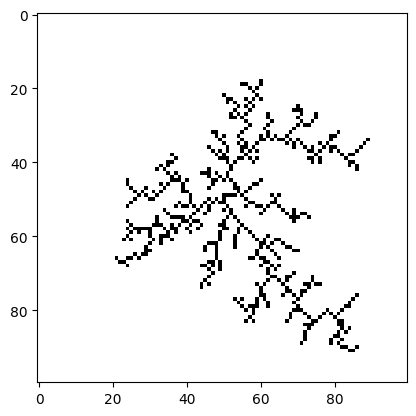

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from IPython import display
import time

rng = np.random.default_rng()

# use display.display to show every step of progress. Gets slow fast
animate_progress = False # @param {type:"boolean"}
# save animation of 
save_animation = False # @param {type:"boolean"}

# Length of one side of the grid
S = 100 # @param {type:"slider", min:5, max:111, step:1}

# World grid
world = []

# aggregate size to stop at
T = 500 # @param {type:"slider", min:5, max:111, step:1}

# Number of active walkers to maintain
W = 50 # @param {type:"slider", min:1, max:100, step:1}

# Collection of active walkers
walkers = []

# Collection of cells currently in the aggregate
aggregate = []

# Chance for a walker to go up+left, up, up+right, left, right, down+left, down, down+right, respectively
chances = [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
# chances = [.25, 0, .25, 0, 0, .25, 0, .25]
summed_chances = [np.sum(chances[0:1:1]), np.sum(chances[0:2:1]),
                  np.sum(chances[0:3:1]), np.sum(chances[0:4:1]),
                  np.sum(chances[0:5:1]), np.sum(chances[0:6:1]),
                  np.sum(chances[0:7:1]), np.sum(chances[0:8:1])]

# displays the current state of world cells
def display_world():
    plt.imshow(world, cmap=plt.get_cmap(cm.Greys))
    display.display(plt.gcf())
    display.clear_output(wait=True)

def get_edge_spot():
    # uncomment to spawn new walkers anywhere rather than only at edges
    # return(rng.integers(S),rng.integers(S))
    edge_offset = rng.integers(1)
    roll = rng.random()
    if roll < 0.25:
        return (edge_offset,rng.integers(S))
    if roll < 0.5:
        return (S-1-edge_offset,rng.integers(S))
    if roll < 0.75:
        return (rng.integers(S),edge_offset)
    else:
        return (rng.integers(S),S-1-edge_offset)

def spawn_new_walker():
    spawn = get_edge_spot()
    while world[spawn[0]][spawn[1]] != 0 or is_aggregate_adjacent(spawn):
        spawn = get_edge_spot()
    world[spawn[0]][spawn[1]] = 1
    walkers.append(spawn)

def is_aggregate_adjacent(cell):
    i = cell[0]
    j = cell[1]
    if world[(i+1)%S][j] == 2:
        return True
    if world[(i+1)%S][(j+1)%S] == 2:
        return True
    if world[(i+1)%S][(j-1)%S] == 2:
        return True
    if world[i][(j+1)%S] == 2:
        return True
    if world[i][(j-1)%S] == 2:
        return True
    if world[(i-1)%S][j] == 2:
        return True
    if world[(i-1)%S][(j+1)%S] == 2:
        return True
    if world[(i-1)%S][(j-1)%S] == 2:
        return True

def update_walker(walker):
    moved = False
    while not moved:
        roll = rng.random()
        if roll < summed_chances[0]: # move up/left
            target = ((walker[0]+1)%S, (walker[1]-1)%S)
        elif roll < summed_chances[1]: # move up
            target = ((walker[0]+1)%S, walker[1])
        elif roll < summed_chances[2]: # move up/right
            target = ((walker[0]+1)%S, (walker[1]+1)%S)
        elif roll < summed_chances[3]: # move left
            target = (walker[0],(walker[1]-1)%S)
        elif roll < summed_chances[4]: # move right
            target = (walker[0],(walker[1]+1)%S)
        elif roll < summed_chances[5]: # move down/left
            target = ((walker[0]-1)%S, (walker[1]-1)%S)
        elif roll < summed_chances[6]: # move down
            target = ((walker[0]-1)%S, walker[1])
        else: # move down/right
            target = ((walker[0]-1)%S, (walker[1]+1)%S)
        
        if world[target[0]][target[1]] == 0:
            if is_aggregate_adjacent(target):
                world[walker[0]][walker[1]] = 0
                walkers.remove(walker)
                world[target[0]][target[1]] = 2
                aggregate.append(target)
            else:
                world[walker[0]][walker[1]] = 0
                world[target[0]][target[1]] = 1
                walkers[walkers.index(walker)] = target
            moved = True

# set up initial world
world = np.zeros((S,S))
world[S//2][S//2] = 2
aggregate.append((S//2,S//2))

# set up initial walkers
for n in range(W):
    spawn_new_walker()

if save_animation:
    img = [] # frame images
    fig = plt.figure()

running = True
while len(aggregate) < T:
    if animate_progress:
        display_world()
    for walker in walkers:
        update_walker(walker)
    while len(walkers) < W:
        spawn_new_walker()
    if save_animation:
        img.append([plt.imshow(world, cmap=plt.get_cmap(cm.Greys))])

# clear walkers from grid
for walker in walkers:
    world[walker[0]][walker[1]] = 0

if save_animation:
    ani = animation.ArtistAnimation(fig=fig, artists=img, interval=100)
    timestamp = time.strftime("%m-%d-%H-%M-%S", time.localtime())
    ani.save(f'animations/{timestamp}-movie.gif', writer="pillow")

display_world()

In [56]:
import numpy as np

def divide_into_boxes(arr, r):
    # Get the size of the original array
    n = arr.shape[0]
    arr = np.array(arr)
    if n % r != 0:
        raise ValueError("The size of the array must be divisible by the block size.")

    # Reshape and swap axes to divide the array into r x r boxes
    boxes = arr.reshape(n // r, r, n // r, r).swapaxes(1, 2)
    return boxes

# Counts number of boxes of size r to cover the structure 
def box_count(arr, r):
    n = 0
    boxes = divide_into_boxes(arr, r)
    for i in range(boxes.shape[0]):
        for j in range(boxes.shape[1]):
            # print(f"Box ({i}, {j}):")
            # print(boxes[i, j])
            # print()
            if np.any(boxes[i,j]>0):
                n += 1

    return n

# Counts boxes to cover structure for all r divisors
def box_count_all_r(world):
    res = []
    arr = world
    n = world.shape[0]
    divisors = [r for r in range(1, n+1) if n % r == 0]
    for r in divisors:
        n = box_count(arr,r)
        res.append((r, r/n, n))
    return res

# Example usage


res = box_count_all_r(world)
print(res)
# boxes = divide_into_boxes(arr, r)

# # Print the resulting blocks
# print(boxes)

# print(f"Shape of blocks: {boxes.shape}")
# print(box_count(arr, r))

[(1, 0.002, 500), (2, 0.006172839506172839, 324), (4, 0.02857142857142857, 140), (5, 0.050505050505050504, 99), (10, 0.2702702702702703, 37), (20, 1.5384615384615385, 13), (25, 2.5, 10), (50, 12.5, 4), (100, 100.0, 1)]


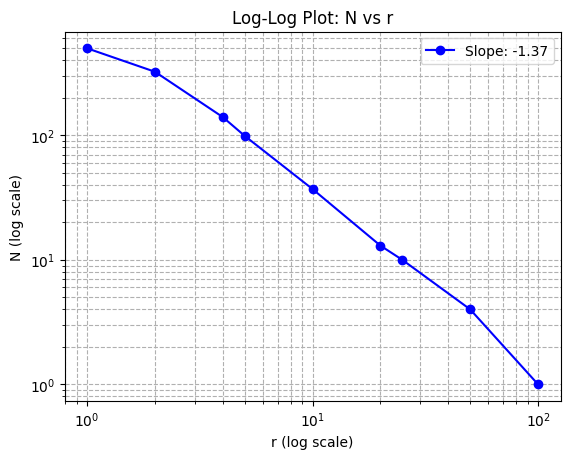

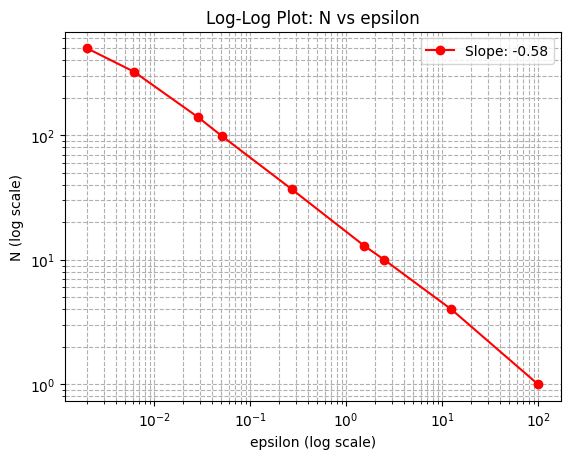

(np.float64(-1.3681598892440963), np.float64(-0.5793493088970227))

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Data: (r, epsilon, N)

# Extracting the columns into individual arrays
r = np.array([x[0] for x in res])
epsilon = np.array([x[1] for x in res])
N = np.array([x[2] for x in res])

def plot_with_slope(x, y, xlabel, ylabel, title, color='b'):
    # Perform log-log regression to calculate slope
    slope, intercept = np.polyfit(np.log10(x), np.log10(y), 1)
    
    # Plot the data
    fig, ax = plt.subplots()
    ax.loglog(x, y, marker='o', linestyle='-', color=color, label=f'Slope: {slope:.2f}')
    ax.set_xlabel(f'{xlabel} (log scale)')
    ax.set_ylabel(f'{ylabel} (log scale)')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, which="both", ls="--")
    return fig, slope

# Create both plots with slopes
fig1, slope1 = plot_with_slope(r, N, 'r', 'N', 'Log-Log Plot: N vs r', 'b')
fig2, slope2 = plot_with_slope(epsilon, N, 'epsilon', 'N', 'Log-Log Plot: N vs epsilon', 'r')

# Display plots
plt.show()

# Print slopes for reference
slope1, slope2